# Data Wrangling 

## Loading Information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score

In [2]:
lending_data = pd.read_csv('lending_data.csv')

In [3]:
lending_data.head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,due_date,completed_at
0,4510000.0,metalworking,3.0,30000.0,359900.0,2021-02-26,2021-02-26
1,7130000.0,fashion,1.0,40000.0,597800.0,2021-12-04,2021-12-14
2,3880000.0,electronics,1.0,21000.0,474700.0,2021-09-01,2021-09-01
3,5590000.0,mobile money,3.0,41000.0,487800.0,2021-08-29,2021-08-24
4,3950000.0,metalworking,4.0,26000.0,381000.0,2021-12-17,2021-12-10


Determine data types

In [4]:
lending_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   monthly_income      20000 non-null  float64
 1   industry            19029 non-null  object 
 2   years_in_operation  18355 non-null  float64
 3   monthly_rent        20000 non-null  float64
 4   principal           20000 non-null  float64
 5   due_date            20000 non-null  object 
 6   completed_at        19421 non-null  object 
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


Convert date features to datetime

In [5]:
def datetime_converter(df, date_feature_list):
    for date_feature in date_feature_list:
        df[date_feature] = df[date_feature].apply(pd.to_datetime)
    
    return df

In [6]:
date_features = ['due_date', 'completed_at']
lending_data = datetime_converter(lending_data, date_features)

In [7]:
lending_data[['due_date', 'completed_at']].head()

,due_date,completed_at
0,2021-02-26,2021-02-26
1,2021-12-04,2021-12-14
2,2021-09-01,2021-09-01
3,2021-08-29,2021-08-24
4,2021-12-17,2021-12-10


In [8]:
lending_data.due_date.dtype, lending_data.completed_at.dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

Missing values

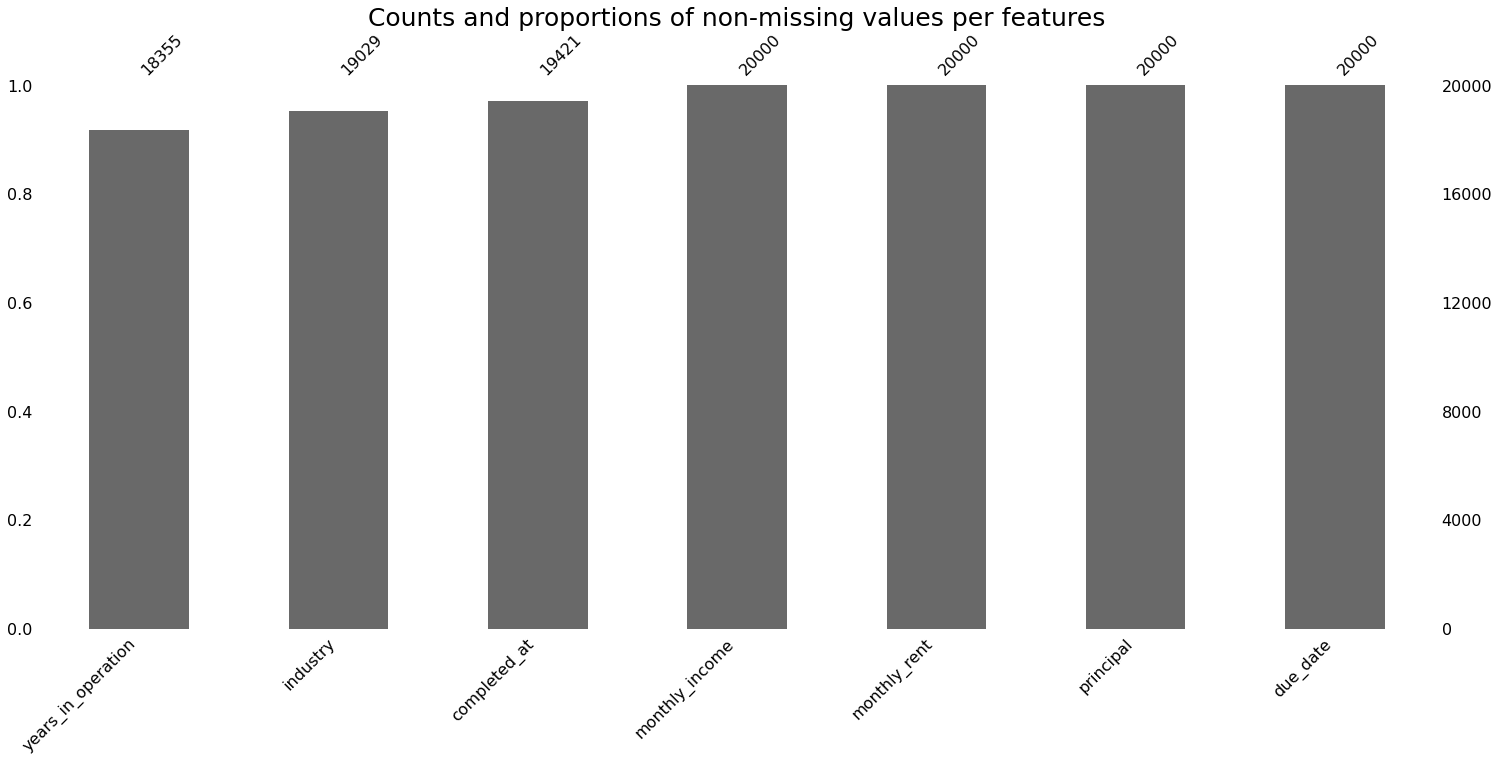

In [9]:
msno.bar(lending_data, sort = 'ascending')
plt.title('Counts and proportions of non-missing values per features', fontsize = 25);

We observe that years_in_operation, industry and completed_at have missing values. 

We know that a completed_at value with no information likely implies that the business defaulted on their loan. 
We can use a placeholder for those businesses who did not specify an industry. 
A business that did not include the number of years_in_operation could either be an oversight or could be an indication that the business was relatively new. This needs to be clarified with Numida.We will review this later on. 

In [10]:
 def data_distributions(feature, unit, df = lending_data):
    fig, axs = plt.subplots(1, 2, figsize = (15, 6))
    
    axs[0].set_title(f'Histogram of {feature}')
    df[feature].plot(kind = 'hist', ax = axs[0])
    axs[0].set_xlabel(f'{feature} ({unit})');

    
    axs[1].set_title(f'Boxplot of {feature}')
    sns.boxplot(data = df, y = feature, ax = axs[1])
    axs[1].set_ylabel(f'{feature} ({unit})');

def boxplots(feature, target = 'default', df = lending_data):
    plt.subplots(figsize =(8,5))
    sns.boxplot(data = df, x = 'default', y = feature)
    

Monthly Income Distribution

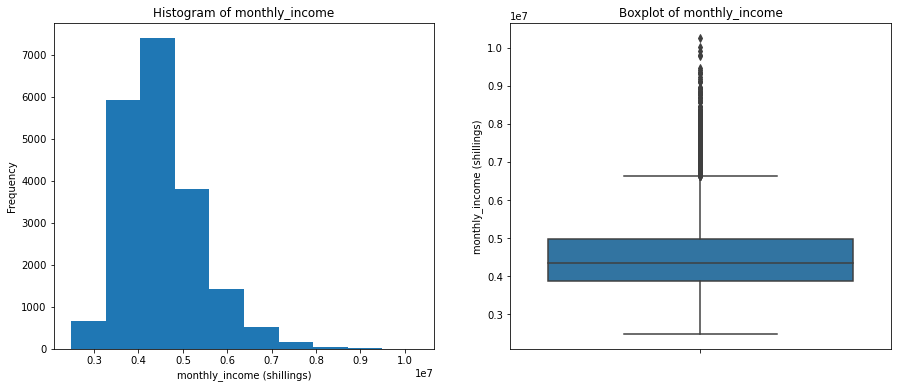

In [11]:
data_distributions('monthly_income', 'shillings')

Distribution of Industry

In [12]:
lending_data.industry.value_counts(dropna = False)

metalworking    3874
staple goods    3836
mobile money    3804
fashion         3795
electronics     3720
NaN              971
Name: industry, dtype: int64

Let's replace the missing values with 'none'. 

In [13]:
lending_data.industry[lending_data.industry.isnull()] = 'none'

<ipython-input-13-71a2f50cd0b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lending_data.industry[lending_data.industry.isnull()] = 'none'


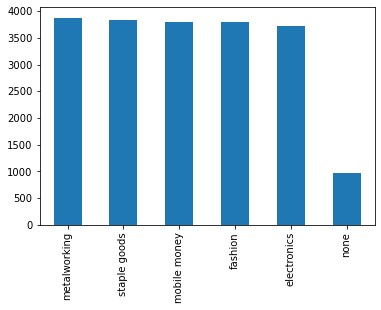

In [14]:
lending_data.industry.value_counts().plot(kind = 'bar');

Distribution of years in operation

In [15]:
lending_data.years_in_operation.value_counts(dropna = False)

4.0    3726
2.0    3718
5.0    3660
1.0    3629
3.0    3622
NaN    1645
Name: years_in_operation, dtype: int64

In [16]:
lending_data[lending_data.years_in_operation.isnull()].head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,due_date,completed_at
10,4410000.0,metalworking,NaN,17000.0,377900.0,2021-11-30,2021-11-25
22,4830000.0,mobile money,NaN,40000.0,421300.0,2021-08-25,2021-08-25
42,3080000.0,fashion,NaN,37000.0,241400.0,2021-03-27,2021-03-26
43,4730000.0,fashion,NaN,16000.0,361400.0,2021-09-16,2021-09-16
59,3880000.0,metalworking,NaN,16000.0,311600.0,2021-09-23,2021-09-27


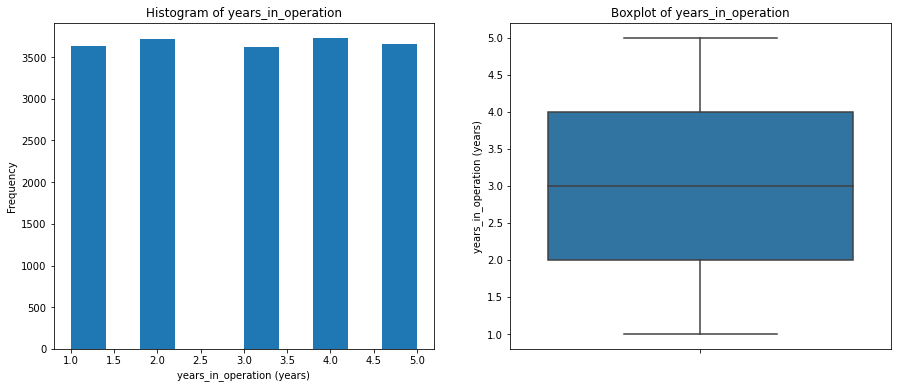

In [17]:
data_distributions('years_in_operation', 'years')

Distribution of monthly rent

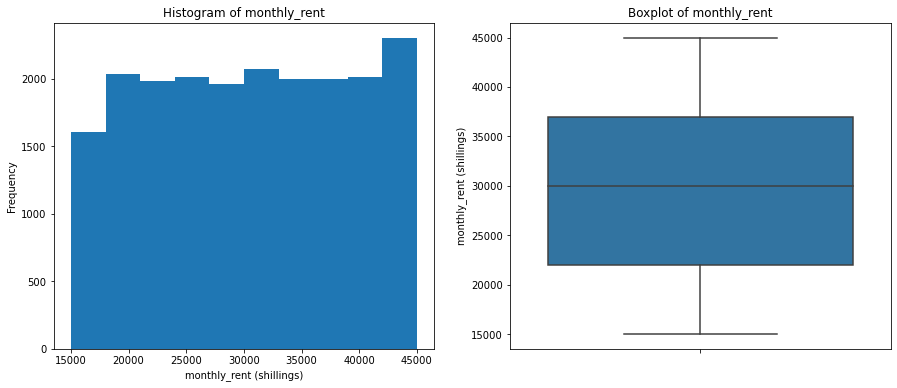

In [18]:
data_distributions('monthly_rent', 'shillings')

Distribution of principal

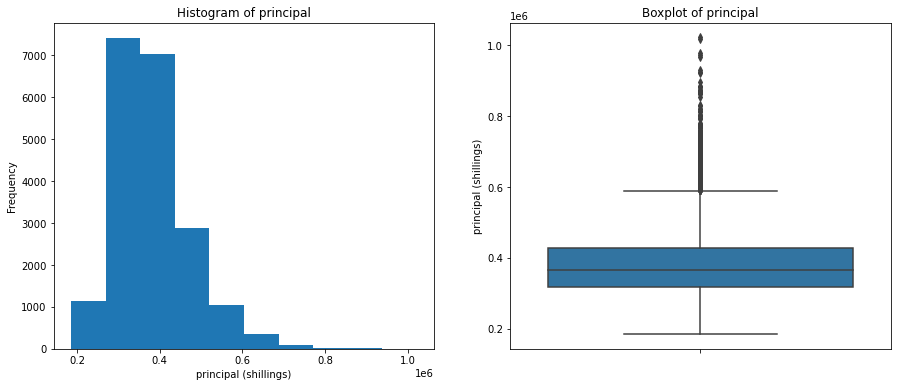

In [19]:
data_distributions('principal', 'shillings')

Missing values for completed_at

Given that completed_at indicates whether a loan has been repaid, we can assume that a null entry means that the loans has not been repaid. This ideally will need to be verified by the business. Since we define our default is being delinquent for over 2 weeks, we will replace the missing completed_at values with the due_data plus 21 days. We choose 21 days to ensure that it the lag is over 14 days. 

In [20]:
missing_completed_mask = lending_data.completed_at.isnull()
lending_data.loc[missing_completed_mask, 'completed_at'] = lending_data.loc[missing_completed_mask, 'due_date'] + pd.Timedelta(days = 21)
lending_data.completed_at.isnull().sum()

0

# Exploratory Data Analysis
    

Check date range of due_date and completed_at

In [21]:
lending_data[['due_date', 'completed_at']].describe(datetime_is_numeric = True)

,due_date,completed_at
count,20000,20000
mean,2021-07-04 08:15:21.600000,2021-07-05 04:19:20.640000
min,2021-01-01 00:00:00,2020-12-25 00:00:00
25%,2021-04-05 00:00:00,2021-04-05 00:00:00
50%,2021-07-05 00:00:00,2021-07-06 00:00:00
75%,2021-10-03 00:00:00,2021-10-04 00:00:00
max,2022-01-01 00:00:00,2022-02-13 00:00:00


Create lag (in days) for delinquent loans

In [22]:
lending_data['lag_days'] = (lending_data.completed_at - lending_data.due_date).dt.days
lending_data.lag_days.head()

0     0
1    10
2     0
3    -5
4    -7
Name: lag_days, dtype: int64

Distribution of lag

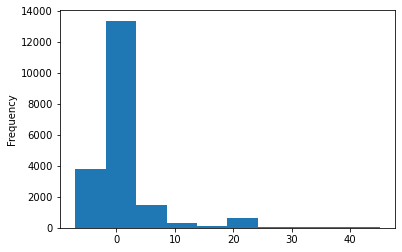

In [23]:
lending_data.lag_days.plot(kind = 'hist');

Create label for defaults

Default is defined as business that doesn't repay loan in 2 weeks (14 days)

In [24]:
lending_data['default'] = lending_data.lag_days > 14
lending_data.default.head()

0    False
1    False
2    False
3    False
4    False
Name: default, dtype: bool

Review distribution of default

In [25]:
lending_data.default.value_counts(normalize = True)

False    0.9518
True     0.0482
Name: default, dtype: float64

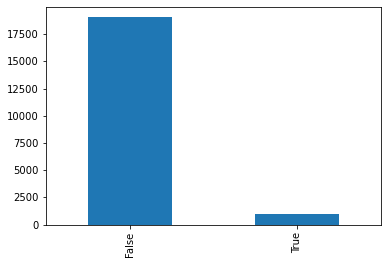

In [26]:
lending_data.default.value_counts().plot(kind = 'bar');

 We note that default rate is low, which is very good, but implies that data is severly imbalanced.

We can examine the features to see if we can spot trends associated with default

Examine relationship between monthly income and default rate

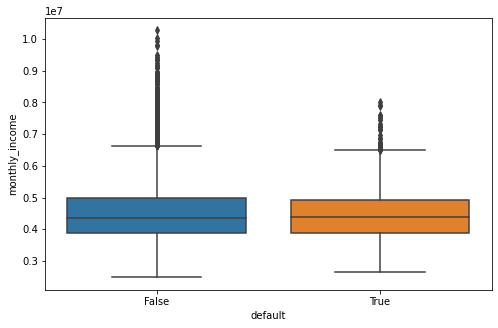

In [27]:
boxplots('monthly_income');

Examine relationship between years in business and default

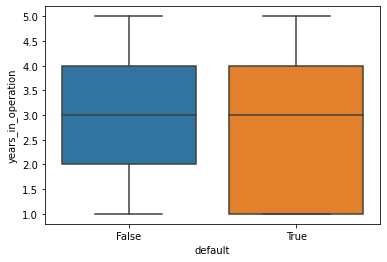

In [28]:
sns.boxplot(data = lending_data, x = 'default', y = 'years_in_operation');

Examine relationship between monthly rent and default

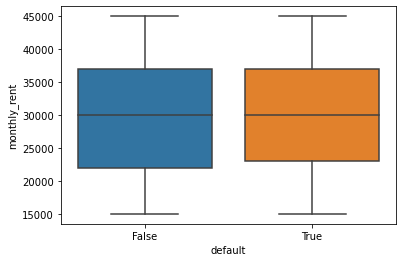

In [29]:
sns.boxplot(data = lending_data, x = 'default', y = 'monthly_rent');

Examine relationship between principal and default

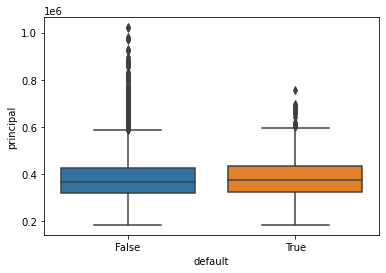

In [30]:
sns.boxplot(data = lending_data, x = 'default', y = 'principal');

Examine relationship between industry and default

In [31]:
industry_split = lending_data.groupby(['industry', 'default']).agg(count = ('default', 'count'))
industry_split.head()

count
industry     default       
electronics  False     3572
             True       148
fashion      False     3637
             True       158
metalworking False     3606

In [32]:
industry_default = industry_split.reset_index()
industry_default.head()

,industry,default,count
0,electronics,False,3572
1,electronics,True,148
2,fashion,False,3637
3,fashion,True,158
4,metalworking,False,3606


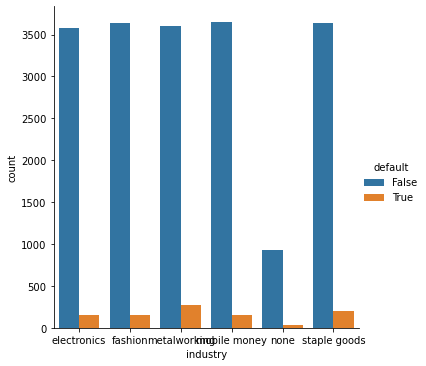

In [33]:
sns.catplot(data = industry_default, x = 'industry', y = 'count', kind = 'bar', hue = 'default');

Determine proportion of defaults per industry

In [34]:
industry_default_perc = industry_split.groupby('industry').apply(lambda x: x / x.sum())\
.rename(columns = {'count': 'perc'})
industry_default_perc

perc
industry     default          
electronics  False    0.960215
             True     0.039785
fashion      False    0.958366
             True     0.041634
metalworking False    0.930821
             True     0.069179
mobile money False    0.960305
             True     0.039695
none         False    0.960865
             True     0.039135
staple goods False    0.947602
             True     0.052398

In [35]:
industry_default_df = industry_default_perc.reset_index()
industry_default_rate = industry_default_df.query('default == True')
industry_default_info = industry_default_rate[['industry', 'perc']].sort_values(by = 'perc', ascending = False).rename(columns = {'perc': 'industry_default_rate'})
industry_default_info

,industry,industry_default_rate
5,metalworking,0.069179
11,staple goods,0.052398
3,fashion,0.041634
1,electronics,0.039785
7,mobile money,0.039695
9,none,0.039135


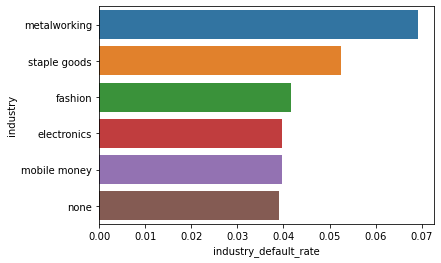

In [36]:
sns.barplot(data = industry_default_info, y = 'industry', x = 'industry_default_rate');

Join industry default rates to dataset

In [37]:
lending = pd.merge(lending_data, industry_default_info, how = 'inner', on = 'industry')
lending.head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,due_date,completed_at,lag_days,default,industry_default_rate
0,4510000.0,metalworking,3.0,30000.0,359900.0,2021-02-26,2021-02-26,0,False,0.069179
1,3950000.0,metalworking,4.0,26000.0,381000.0,2021-12-17,2021-12-10,-7,False,0.069179
2,3800000.0,metalworking,3.0,35000.0,375000.0,2021-09-18,2021-09-17,-1,False,0.069179
3,5130000.0,metalworking,5.0,42000.0,548300.0,2021-03-19,2021-04-09,21,True,0.069179
4,4130000.0,metalworking,4.0,45000.0,410400.0,2021-08-15,2021-08-15,0,False,0.069179


# Data Pre-processing and Training Data Development 

Since we do not know any date information prior to issuing a loan, we will drop all time related data. This includes completed_at, due_date and lag_days.

In [38]:
lending_inter = lending[['monthly_income', 'industry', 'years_in_operation', 'monthly_rent',
       'principal', 'default', 'industry_default_rate']]
lending_inter.head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,default,industry_default_rate
0,4510000.0,metalworking,3.0,30000.0,359900.0,False,0.069179
1,3950000.0,metalworking,4.0,26000.0,381000.0,False,0.069179
2,3800000.0,metalworking,3.0,35000.0,375000.0,False,0.069179
3,5130000.0,metalworking,5.0,42000.0,548300.0,True,0.069179
4,4130000.0,metalworking,4.0,45000.0,410400.0,False,0.069179


Collect a sample of 10 defaulted and 10 non-defaulted loans for later assessment

In [39]:
sample = lending_inter.groupby(['default', 'industry']).apply(lambda x: x.sample(2))
sample

monthly_income      industry  years_in_operation  \
default industry                                                               
False   electronics  9428        4730000.0   electronics                 5.0   
                     9142        4040000.0   electronics                 3.0   
        fashion      5063        4250000.0       fashion                 3.0   
                     7532        4450000.0       fashion                 1.0   
        metalworking 1444        4390000.0  metalworking                 2.0   
                     2959        3180000.0  metalworking                 4.0   
        mobile money 13578       6100000.0  mobile money                 4.0   
                     12781       7280000.0  mobile money                 3.0   
        none         19145       7130000.0          none                 4.0   
                     19351       5580000.0          none                 3.0   
        staple goods 15460       4780000.0  staple goods                 4.0   
                     16712       5890000.0  staple goods                 3.0   
True    electronics  10251       3590000.0   electronics                 4.0   
                     8791        4060000.0   electronics                 2.0   
        fashion      7497        4070000.0       fashion                 5.0   
                     6533        4990000.0       fashion                 1.0   
        metalworking 2182        7310000.0  metalworking                 3.0   
                     3052        3260000.0  metalworking                 1.0   
        mobile money 14507       5090000.0  mobile money                 2.0   
                     14438       4060000.0  mobile money                 1.0   
        none         19085       3800000.0          none                 3.0   
                     19887       4430000.0          none                 3.0   
        staple goods 16719       5550000.0  staple goods                 1.0   
                     16859       3700000.0  staple goods                 NaN   

                            monthly_rent  principal  default  \
default industry                                               
False   electronics  9428        38000.0   364900.0    False   
                     9142        21000.0   328700.0    False   
        fashion      5063        42000.0   360600.0    False   
                     7532        40000.0   348000.0    False   
        metalworking 1444        23000.0   331100.0    False   
                     2959        17000.0   257800.0    False   
        mobile money 13578       34000.0   609000.0    False   
                     12781       43000.0   611200.0    False   
        none         19145       39000.0   897600.0    False   
                     19351       39000.0   386800.0    False   
        staple goods 15460       38000.0   439100.0    False   
                     16712       18000.0   462400.0    False   
True    electronics  10251       40000.0   290300.0     True   
                     8791        29000.0   405200.0     True   
        fashion      7497        40000.0   309600.0     True   
                     6533        38000.0   386800.0     True   
        metalworking 2182        35000.0   611100.0     True   
                     3052        25000.0   270700.0     True   
        mobile money 14507       16000.0   411200.0     True   
                     14438       26000.0   358200.0     True   
        none         19085       24000.0   294900.0     True   
                     19887       19000.0   341300.0     True   
        staple goods 16719       32000.0   507100.0     True   
                     16859       21000.0   404600.0     True   

                            industry_default_rate  
default industry                                   
False   electronics  9428                0.039785  
                     9142                0.039785  
        fashion      5063                0.041634  
                     7

We will store this dataframe as our sample data and remove these observations from the original dataset.

In [40]:
sample_indexes = list(pd.MultiIndex.from_arrays(sample.index)[2])

In [41]:
sample_final = lending_inter.iloc[sample_indexes]
sample_final.head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,default,industry_default_rate
9428,4730000.0,electronics,5.0,38000.0,364900.0,False,0.039785
9142,4040000.0,electronics,3.0,21000.0,328700.0,False,0.039785
5063,4250000.0,fashion,3.0,42000.0,360600.0,False,0.041634
7532,4450000.0,fashion,1.0,40000.0,348000.0,False,0.041634
1444,4390000.0,metalworking,2.0,23000.0,331100.0,False,0.069179


In [42]:
mask_sample_indexes = lending_inter.index.isin(sample_indexes)
lending_inter_2 = lending_inter[~mask_sample_indexes]

In [43]:
lending_inter_2.head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,default,industry_default_rate
0,4510000.0,metalworking,3.0,30000.0,359900.0,False,0.069179
1,3950000.0,metalworking,4.0,26000.0,381000.0,False,0.069179
2,3800000.0,metalworking,3.0,35000.0,375000.0,False,0.069179
3,5130000.0,metalworking,5.0,42000.0,548300.0,True,0.069179
4,4130000.0,metalworking,4.0,45000.0,410400.0,False,0.069179


Encoding categorical features and storing the default status separately

In [44]:
lending_inter_2.loc[:, 'default'] = lending_inter_2.loc[:, 'default'].astype(int)

C:\Users\zebin\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [45]:
lending_inter_2.default.value_counts()

0    19024
1      952
Name: default, dtype: int64

Encoding categorical data

In [46]:
lending_modelling = pd.get_dummies(lending_inter_2, drop_first = True)
lending_modelling.head()

,monthly_income,years_in_operation,monthly_rent,principal,default,industry_default_rate,industry_fashion,industry_metalworking,industry_mobile money,industry_none,industry_staple goods
0,4510000.0,3.0,30000.0,359900.0,0,0.069179,0,1,0,0,0
1,3950000.0,4.0,26000.0,381000.0,0,0.069179,0,1,0,0,0
2,3800000.0,3.0,35000.0,375000.0,0,0.069179,0,1,0,0,0
3,5130000.0,5.0,42000.0,548300.0,1,0.069179,0,1,0,0,0
4,4130000.0,4.0,45000.0,410400.0,0,0.069179,0,1,0,0,0


Replace missing values of years_in_operation with the mean

In [47]:
mean_years = lending_modelling.years_in_operation.mean()
lending_modelling.loc[lending_modelling.years_in_operation.isnull(), 'years_in_operation'] = mean_years
lending_modelling.years_in_operation.isnull().sum()

0

In [48]:
X = lending_modelling.drop(columns = ['default'])
y = lending_modelling.default
X_features = X.columns
X_features

Index(['monthly_income', 'years_in_operation', 'monthly_rent', 'principal',
       'industry_default_rate', 'industry_fashion', 'industry_metalworking',
       'industry_mobile money', 'industry_none', 'industry_staple goods'],
      dtype='object')

Scaling the features

In [49]:
scaler = StandardScaler(with_mean = False)
X_scaled = scaler.fit_transform(X)

# Create Train-Test Split 

In [50]:
#Split X and y to test and training set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify = y, random_state = 77)

In [51]:
X_train.shape, X_test.shape

((13983, 10), (5993, 10))

In [52]:
y_train.shape, y_test.shape

((13983,), (5993,))

In [53]:
y_train.value_counts(normalize = True)

0    0.952371
1    0.047629
Name: default, dtype: float64

In [54]:
y_test.value_counts(normalize = True)

0    0.952278
1    0.047722
Name: default, dtype: float64

# Baseline Model 

In [55]:
logreg = LogisticRegression(penalty = 'none', class_weight = {1: 95, 0: 5}, random_state = 77)

In [56]:
logreg.fit(X_train, y_train);

In [57]:
y_pred = logreg.predict(X_test)

In [58]:
y_pred_prob_logreg = logreg.predict_proba(X_test)[:,1]

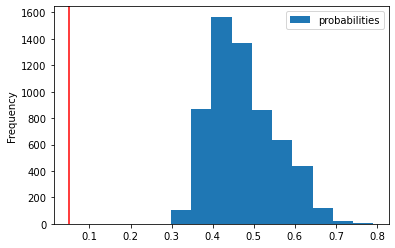

In [59]:
pd.DataFrame(y_pred_prob_logreg, columns = ['probabilities']).plot(kind = 'hist')
plt.axvline(0.05, c = 'red');

Model Assessment

In [60]:
confusion_matrix(y_test, y_pred)

array([[3850, 1857],
       [ 167,  119]], dtype=int64)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79      5707
           1       0.06      0.42      0.11       286

    accuracy                           0.66      5993
   macro avg       0.51      0.55      0.45      5993
weighted avg       0.92      0.66      0.76      5993



In [62]:
average_precision_score(y_test, y_pred_prob_logreg)

0.05792001400755922

Precision - Recall curve

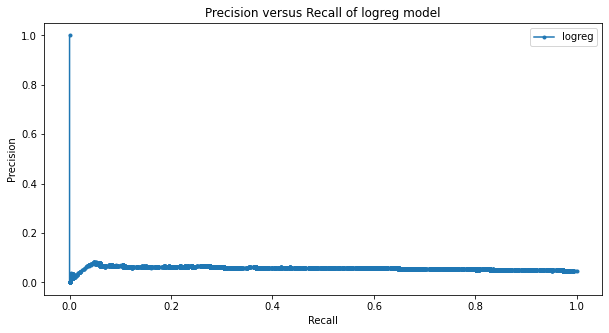

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_logreg) 
plt.figure(figsize = (10, 5))
plt.title(f'Precision versus Recall of logreg model')
plt.plot(recall, precision, marker = '.', label = 'logreg', zorder = -1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Applying model to sample

In [64]:
sample_final.head()

,monthly_income,industry,years_in_operation,monthly_rent,principal,default,industry_default_rate
9428,4730000.0,electronics,5.0,38000.0,364900.0,False,0.039785
9142,4040000.0,electronics,3.0,21000.0,328700.0,False,0.039785
5063,4250000.0,fashion,3.0,42000.0,360600.0,False,0.041634
7532,4450000.0,fashion,1.0,40000.0,348000.0,False,0.041634
1444,4390000.0,metalworking,2.0,23000.0,331100.0,False,0.069179


Pre-processing the sample

In [65]:
sample_modelling = pd.get_dummies(sample_final, drop_first = True)
sample_modelling.loc[sample_modelling.years_in_operation.isnull(), 'years_in_operation'] = mean_years
sample_modelling.years_in_operation.isnull().sum()

0

In [66]:
X_sample = sample_modelling.drop(columns = ['default'])
y = sample_modelling.default
X_sample_features = X_sample.columns
X_sample_features

Index(['monthly_income', 'years_in_operation', 'monthly_rent', 'principal',
       'industry_default_rate', 'industry_fashion', 'industry_metalworking',
       'industry_mobile money', 'industry_none', 'industry_staple goods'],
      dtype='object')

In [67]:
sample_scaler = StandardScaler(with_mean = False)
X_sample_scaled = sample_scaler.fit_transform(X_sample)

In [68]:
y_pred_prob_sample = logreg.predict_proba(X_sample_scaled)[:,1]

In [69]:
sample_final.loc[:, 'probabilities'] = y_pred_prob_sample

C:\Users\zebin\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\zebin\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [70]:
sample_final.query('default == True')

,monthly_income,industry,years_in_operation,monthly_rent,principal,default,industry_default_rate,probabilities
10251,3590000.0,electronics,4.0,40000.0,290300.0,True,0.039785,0.326263
8791,4060000.0,electronics,2.0,29000.0,405200.0,True,0.039785,0.403674
7497,4070000.0,fashion,5.0,40000.0,309600.0,True,0.041634,0.352235
6533,4990000.0,fashion,1.0,38000.0,386800.0,True,0.041634,0.426651
2182,7310000.0,metalworking,3.0,35000.0,611100.0,True,0.069179,0.537549
3052,3260000.0,metalworking,1.0,25000.0,270700.0,True,0.069179,0.595874
14507,5090000.0,mobile money,2.0,16000.0,411200.0,True,0.039695,0.402958
14438,4060000.0,mobile money,1.0,26000.0,358200.0,True,0.039695,0.437895
19085,3800000.0,none,3.0,24000.0,294900.0,True,0.039135,0.339442
19887,4430000.0,none,3.0,19000.0,341300.0,True,0.039135,0.336824


In [71]:
sample_final.query('default == False')

,monthly_income,industry,years_in_operation,monthly_rent,principal,default,industry_default_rate,probabilities
9428,4730000.0,electronics,5.0,38000.0,364900.0,False,0.039785,0.297071
9142,4040000.0,electronics,3.0,21000.0,328700.0,False,0.039785,0.352211
5063,4250000.0,fashion,3.0,42000.0,360600.0,False,0.041634,0.406109
7532,4450000.0,fashion,1.0,40000.0,348000.0,False,0.041634,0.430786
1444,4390000.0,metalworking,2.0,23000.0,331100.0,False,0.069179,0.555885
2959,3180000.0,metalworking,4.0,17000.0,257800.0,False,0.069179,0.537853
13578,6100000.0,mobile money,4.0,34000.0,609000.0,False,0.039695,0.408259
12781,7280000.0,mobile money,3.0,43000.0,611200.0,False,0.039695,0.371058
19145,7130000.0,none,4.0,39000.0,897600.0,False,0.039135,0.462157
19351,5580000.0,none,3.0,39000.0,386800.0,False,0.039135,0.301106
